# BBO-Rietveld DSMO

In this notebook, you can see how to automate Rietveld refinement with black-box optimization.  
Run the following cells to run the optimization.

## Documentations
- [JupyterLab](https://jupyterlab.readthedocs.io/en/stable/)
- [GSASIIscriptable: Scripting Interface](https://gsas-ii.readthedocs.io/en/latest/GSASIIscriptable.html)
- [Optuna](https://optuna.readthedocs.io/en/stable/)

In [1]:
# import packages

import os
import sys
from multiprocessing import Process, Queue
import pandas as pd
import optuna
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from dataclasses import dataclass
sys.path.append('/root/g2full/GSASII/')


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configurations
RANDOM_SEED = 1024
STUDY_NAME = 'DSMO'
DATA_DIR = 'data/' + STUDY_NAME
# all output files include GSAS project file (*.gpx) will be saved in WORK_DIR
WORK_DIR = 'work/' + STUDY_NAME

In [3]:
# make directories
! rm -f $WORK_DIR/*
! mkdir -p $WORK_DIR

In [4]:
@dataclass
class ProjectConfig:
    work_dir: str
    random_seed: int
    data_dir: str
    init_gpx_file: str
    two_t_min: int
    two_t_max: int
    
class Project:
    def __init__(self, config: ProjectConfig, trial_number: int):
        import GSASIIscriptable as G2sc
        import shutil

        # Create a project with a default project name
        shutil.copyfile(os.path.join(config.data_dir, config.init_gpx_file),
                        os.path.join(config.work_dir, f'project_seed{config.random_seed}_trial_{trial_number}.gpx'))
        self.gpx = G2sc.G2Project(gpxfile=os.path.join(
            config.work_dir, f'project_seed{config.random_seed}_trial_{trial_number}.gpx'))

        # Add two histograms to the project
        self.hist1 = self.gpx.histograms()[0]
        self.phase0 = self.gpx.phases()[0]
        self.hist1.data['Instrument Parameters'][0]['I(L2)/I(L1)'] = [0.5, 0.5, 0]

        # Set to use iso
        for val in self.phase0.data['Atoms']:
            val[9] = 'I'

    def refine_and_calc_Rwp(self, param_dict):
        self.gpx.do_refinements([param_dict])
        for hist in self.gpx.histograms():
            _, Rwp = hist.name, hist.get_wR()
        return Rwp

In the objective function, first, configurations for the following parameters are sampled.
Then, the crystal structure is refined by GSAS-II.
Finally, the calculated Rwp is returned.

| Parameter                                 | Parameter type   | Search space                                                                                                      |
|-------------------------------------------|------------------|-------------------------------------------------------------------------------------------------------------------|
| initial 2theta bound refinement           | categorical      | {True, False}                                                                                                      |
| initial 2theta lower bound (deg.)         | real             | [15, 80]                                                                                                          |
| initial 2theta upper bound (deg.)         | real/conditional | [l + 20, 100] (l is the initial 2theta lower bound)                                                                |
| background function                       | categorical      | {Chebyshev, cosine, Q^2 power series, Q^-2 power series, linear interpolate, inverse interpolate, log interpolate} |
| degree of background function             | initegral        | [1, 15]                                                                                                            |
| instrument zero position refinement       | categorical      | {True, False}                                                                                                      |
| sample shift X refinement                 | categorical      | {True, False}                                                                                                      |
| sample shift Y refinement                 | categorical      | {True, False}                                                                                                      |
| scale factor refinement                   | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Gaussian: U, V, W) | categorical      | {True, False}                                                                                                      |
| peak shape refinement (Lorentzian: X, Y)  | categorical      | {True, False}                                                                                                      |
| peak shape refinement (SH/L)              | categorical      | {True, False}                                                                                                      |

In [5]:
def objective(trial, config):
    """
    objective function for Optuna.
    
    You can apply black-box optimization for other data analysis 
    by modifying this function for that task.
    
    Parameters
    ----------
    trial : optuna.trial object

    Returns
    -------
    Rwp : float
    
    """
    
    ### define search space ###
    # Limits (acute angle)
    limits_lb = trial.suggest_float('Limits lower bound', config.two_t_min, config.two_t_max- 20)
    limits_ub = trial.suggest_float('Limits upper bound', limits_lb + 20, config.two_t_max)
    limits_refine = trial.suggest_categorical('limits refine', [True, False])
    refdict0 = {'set': {'Limits': [limits_lb, limits_ub]}, 'refine': limits_refine}

    # Background
    background_type = trial.suggest_categorical(
        'Background type', ['chebyschev',
                            'cosine',
                            'Q^2 power series',
                            'Q^-2 power series',
                            'lin interpolate',
                            'inv interpolate',
                            'log interpolate'])
    no_coeffs = trial.suggest_int('Number of coefficients', 1, 15)  # [1, 15]
    background_refine = trial.suggest_categorical('Background refine', [True, False])
    refdict0bg_h = {
        'set': {
            'Background': {
                'type': background_type,
                'no. coeffs': no_coeffs,
                'refine': background_refine
            }
        }
    }

    # Instrument parameters
    instrument_parameters1_refine = []
    for p in ['Zero']:
        if trial.suggest_categorical('Instrument_parameters refine %s' % (p), [True, False]):
            instrument_parameters1_refine.append(p)
    refdict1_h = {'set': {'Cell': True, 'Instrument Parameters': instrument_parameters1_refine}}

    sample_parameters1_refine =[]
    for p in ['DisplaceX', 'DisplaceY', 'Scale']:
        if trial.suggest_categorical('Sample_parameters refine %s' % (p), [True, False]):
            sample_parameters1_refine.append(p)
    refdict1_h2 = {"set": {'Sample Parameters':sample_parameters1_refine }}

    instrument_parameters2_refine = []
    for p in ['U', 'V', 'W', 'X', 'Y', 'SH/L']:
        if trial.suggest_categorical('Peakshape_parameters refine %s' % (p), [True, False]):
            instrument_parameters2_refine.append(p)
    refdict2_h = {'set': {'Instrument Parameters': instrument_parameters2_refine}}

    refdict3_h = {'set': {'Atoms': {'all': 'XU'}}}

    # Limits (wide angle)
    refdict_fin_h = {'set': {'Limits': [config.two_t_min, config.two_t_max]}, 'refine': True}

    # Evaluate
    refine_params_list = [refdict0,
                          refdict0bg_h,
                          refdict1_h,
                          refdict1_h2,
                          refdict2_h,
                          refdict3_h,
                          refdict_fin_h]
    q_Rwp = Queue()
    
    ERROR_PENALTY = 1e9
    def evaluate(config, trial_number, refine_params_list, q_Rwp):
        try:
            print(config)
            print(trial_number)
            print(refine_params_list)
            project = Project(config, trial_number)
            for params in refine_params_list:
                Rwp = project.refine_and_calc_Rwp(params)                    
            # validate Uiso >= 0
            phase_Y2O3 = project.gpx.phases()[0]
            u_iso_list = [atom.uiso for atom in phase_Y2O3.atoms()]
            if min(u_iso_list) < 0:
                # Uiso < 0
                Rwp = ERROR_PENALTY
            q_Rwp.put(Rwp)
            
            # # CIF export
            # exported_cif_path = os.path.join(config.WORK_DIR, project_name+“.cif”)
            # phase.export_CIF(exported_cif_path, quickmode=True)
            
        except Exception as e:
            # Refinement failed
            print(e, file=sys.stderr)
            q_Rwp.put(ERROR_PENALTY)
            
    p = Process(target=evaluate, args=(config, trial.number, refine_params_list, q_Rwp))
    p.start()
    Rwp = ERROR_PENALTY
    try:
            Rwp = q_Rwp.get(timeout=30)
    except Exception as e:
        print(f"Error getting Rwp value: {e}")
    finally:
        p.terminate()
    
    return Rwp


In [6]:
config = ProjectConfig(
    work_dir=WORK_DIR,
    random_seed=RANDOM_SEED,
    data_dir=DATA_DIR,
    init_gpx_file='DSMO_init.gpx',
    two_t_min=15,
    two_t_max=100
)

In [7]:
study = optuna.create_study(study_name=STUDY_NAME + '_seed%s' % (RANDOM_SEED),
                            storage=f"sqlite:///{config.work_dir}/history_sqlite.db", 
                            load_if_exists=True,
                            sampler=optuna.samplers.TPESampler(n_startup_trials=20, seed=RANDOM_SEED))

[I 2024-10-19 04:51:19,240] A new study created in RDB with name: DSMO_seed1024


Run 200 refinements to find the best configuration. It may take abount an hour to complete.

In [8]:
# Optimize
study.optimize(func=lambda trial: objective(trial, config), n_trials=100)

ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
0
[{'set': {'Limits': [57.09992999302858, 99.92932076301099]}, 'refine': False}, {'set': {'Background': {'type': 'cosine', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['U', 'V', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_0.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 

[I 2024-10-19 04:51:49,403] Trial 0 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 57.09992999302858, 'Limits upper bound': 99.92932076301099, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 0 with value: 1000000000.0.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
1
[{'set': {'Limits': [42.18796505222297, 91.4802436234939]}, 'refine': True}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 14, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['V', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_1.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No param

[I 2024-10-19 04:51:54,451] Trial 1 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 42.18796505222297, 'Limits upper bound': 91.4802436234939, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficients': 14, 'Background refine': False, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 0 with value: 1000000000.0.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
2
[{'set': {'Limits': [26.031179159023225, 64.99458812960373]}, 'refine': False}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 11, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY']}}, {'set': {'Instrument Parameters': ['U', 'V', 'W', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_2.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:51:58,362] Trial 2 finished with value: 18.524616209902263 and parameters: {'Limits lower bound': 26.031179159023225, 'Limits upper bound': 64.99458812960373, 'limits refine': False, 'Background type': 'chebyschev', 'Number of coefficients': 11, 'Background refine': False, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 2 with value: 18.524616209902263.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
3
[{'set': {'Limits': [55.76448359531941, 88.42879804058572]}, 'refine': False}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 11, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY']}}, {'set': {'Instrument Parameters': ['Y', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_3.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will i

[I 2024-10-19 04:52:02,423] Trial 3 finished with value: 18.402479448240936 and parameters: {'Limits lower bound': 55.76448359531941, 'Limits upper bound': 88.42879804058572, 'limits refine': False, 'Background type': 'chebyschev', 'Number of coefficients': 11, 'Background refine': False, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}. Best is trial 3 with value: 18.402479448240936.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
4
[{'set': {'Limits': [47.220757143154756, 91.41029005416827]}, 'refine': False}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 2, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['Scale']}}, {'set': {'Instrument Parameters': ['U', 'V', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_4.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore eq

[I 2024-10-19 04:52:32,547] Trial 4 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 47.220757143154756, 'Limits upper bound': 91.41029005416827, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficients': 2, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 3 with value: 18.402479448240936.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
5
[{'set': {'Limits': [29.92809963276919, 71.68820705162418]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 5, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY']}}, {'set': {'Instrument Parameters': ['U', 'W', 'X', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_5.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2

[I 2024-10-19 04:53:02,680] Trial 5 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 29.92809963276919, 'Limits upper bound': 71.68820705162418, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 5, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 3 with value: 18.402479448240936.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
6
[{'set': {'Limits': [42.42853840605159, 80.21735204950758]}, 'refine': False}, {'set': {'Background': {'type': 'inv interpolate', 'no. coeffs': 5, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['U', 'V', 'W']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_6.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will 

/root/g2full/GSASII/GSASIIstrMain.py:387: RuntimeWarning: invalid value encountered in divide
  Rvals['Max shft/sig'] = np.max(np.nan_to_num(Lastshft/sig))


Maximum shift/esd = 42.510 for all cycles
Error: 1 Parameter(s) dropped:
  :0:Back;2
SVD problem(s) likely from:
  :0:Back;4
Check covariance matrix for parameter correlation
Read from file:/workspace/work/DSMO/project_seed1024_trial_6.bak0.gpx
Save to file  :/workspace/work/DSMO/project_seed1024_trial_6.gpx
GPX file save successful
 Refinement results are in file: /workspace/work/DSMO/project_seed1024_trial_6.lst
 ***** Refinement successful *****
Reported from refinement:
Error: 1 Parameter(s) dropped:
:0:Back;2Warning: Soft (SVD) singularity in the Hessian
SVD problem(s) likely from:
:0:Back;4
Check covariance matrix for parameter correlation
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_6.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dA

[I 2024-10-19 04:53:06,743] Trial 6 finished with value: 33.02633001313666 and parameters: {'Limits lower bound': 42.42853840605159, 'Limits upper bound': 80.21735204950758, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficients': 5, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}. Best is trial 3 with value: 18.402479448240936.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
7
[{'set': {'Limits': [46.85066129249424, 88.1312682434477]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 4, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_7.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ign

[I 2024-10-19 04:53:11,123] Trial 7 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 46.85066129249424, 'Limits upper bound': 88.1312682434477, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 4, 'Background refine': False, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 3 with value: 18.402479448240936.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
8
[{'set': {'Limits': [73.86664056377731, 96.4867039982054]}, 'refine': False}, {'set': {'Background': {'type': 'inv interpolate', 'no. coeffs': 9, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['Scale']}}, {'set': {'Instrument Parameters': ['V', 'X', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_8.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equival

/root/g2full/GSASII/GSASIIstrMain.py:387: RuntimeWarning: invalid value encountered in divide
  Rvals['Max shft/sig'] = np.max(np.nan_to_num(Lastshft/sig))


Maximum shift/esd = 22.372 for all cycles
Error: 5 Parameter(s) dropped:
  :0:Back;2, :0:Back;3, :0:Back;4, :0:Back;5, :0:Back;6
SVD problem(s) likely from:
  :0:Back;8
Check covariance matrix for parameter correlation
Read from file:/workspace/work/DSMO/project_seed1024_trial_8.bak0.gpx
Save to file  :/workspace/work/DSMO/project_seed1024_trial_8.gpx
GPX file save successful
 Refinement results are in file: /workspace/work/DSMO/project_seed1024_trial_8.lst
 ***** Refinement successful *****
Reported from refinement:
Error: 5 Parameter(s) dropped:
:0:Back;2, :0:Back;3, :0:Back;4, :0:Back;5, :0:Back;6Warning: Soft (SVD) singularity in the Hessian
SVD problem(s) likely from:
:0:Back;8
Check covariance matrix for parameter correlation
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_8.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No pa

[I 2024-10-19 04:53:15,351] Trial 8 finished with value: 52.22770266706558 and parameters: {'Limits lower bound': 73.86664056377731, 'Limits upper bound': 96.4867039982054, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficients': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 3 with value: 18.402479448240936.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
9
[{'set': {'Limits': [64.81458087698294, 86.91221004050645]}, 'refine': True}, {'set': {'Background': {'type': 'Q^-2 power series', 'no. coeffs': 14, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['Y', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_9.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Probl

[I 2024-10-19 04:53:45,461] Trial 9 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 64.81458087698294, 'Limits upper bound': 86.91221004050645, 'limits refine': True, 'Background type': 'Q^-2 power series', 'Number of coefficients': 14, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}. Best is trial 3 with value: 18.402479448240936.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
10
[{'set': {'Limits': [42.834226628916085, 64.96908780264376]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 9, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_10.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2


[I 2024-10-19 04:53:48,762] Trial 10 finished with value: 10.116179523465968 and parameters: {'Limits lower bound': 42.834226628916085, 'Limits upper bound': 64.96908780264376, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
11
[{'set': {'Limits': [79.96221996664026, 99.99197948234627]}, 'refine': True}, {'set': {'Background': {'type': 'Q^-2 power series', 'no. coeffs': 11, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['DisplaceX', 'Scale']}}, {'set': {'Instrument Parameters': ['U', 'V', 'W', 'X', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_11.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters var

[I 2024-10-19 04:54:18,890] Trial 11 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 79.96221996664026, 'Limits upper bound': 99.99197948234627, 'limits refine': True, 'Background type': 'Q^-2 power series', 'Number of coefficients': 11, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 10 with value: 10.116179523465968.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
12
[{'set': {'Limits': [60.126341779050705, 88.02953643040544]}, 'refine': False}, {'set': {'Background': {'type': 'inv interpolate', 'no. coeffs': 5, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['DisplaceX', 'Scale']}}, {'set': {'Instrument Parameters': ['V', 'X', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_12.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No 

/root/g2full/GSASII/GSASIIstrMain.py:387: RuntimeWarning: invalid value encountered in divide
  Rvals['Max shft/sig'] = np.max(np.nan_to_num(Lastshft/sig))


Maximum shift/esd = 41.839 for all cycles
Error: 1 Parameter(s) dropped:
  :0:Back;2
SVD problem(s) likely from:
  :0:Back;4
Check covariance matrix for parameter correlation
Read from file:/workspace/work/DSMO/project_seed1024_trial_12.bak0.gpx
Save to file  :/workspace/work/DSMO/project_seed1024_trial_12.gpx
GPX file save successful
 Refinement results are in file: /workspace/work/DSMO/project_seed1024_trial_12.lst
 ***** Refinement successful *****
Reported from refinement:
Error: 1 Parameter(s) dropped:
:0:Back;2Warning: Soft (SVD) singularity in the Hessian
SVD problem(s) likely from:
:0:Back;4
Check covariance matrix for parameter correlation
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_12.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0

[I 2024-10-19 04:54:49,015] Trial 12 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 60.126341779050705, 'Limits upper bound': 88.02953643040544, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficients': 5, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 10 with value: 10.116179523465968.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
13
[{'set': {'Limits': [42.48705467349322, 73.65448691979742]}, 'refine': False}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 11, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['U', 'V', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_13.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0:

[I 2024-10-19 04:54:52,531] Trial 13 finished with value: 17.443666795282812 and parameters: {'Limits lower bound': 42.48705467349322, 'Limits upper bound': 73.65448691979742, 'limits refine': False, 'Background type': 'chebyschev', 'Number of coefficients': 11, 'Background refine': False, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
14
[{'set': {'Limits': [31.556447537032664, 98.38164841109133]}, 'refine': False}, {'set': {'Background': {'type': 'cosine', 'no. coeffs': 10, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX']}}, {'set': {'Instrument Parameters': ['U', 'X', 'Y', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_14.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore

[I 2024-10-19 04:55:22,652] Trial 14 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 31.556447537032664, 'Limits upper bound': 98.38164841109133, 'limits refine': False, 'Background type': 'cosine', 'Number of coefficients': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}. Best is trial 10 with value: 10.116179523465968.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
15
[{'set': {'Limits': [29.296037443197257, 66.55602745961708]}, 'refine': True}, {'set': {'Background': {'type': 'cosine', 'no. coeffs': 6, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['U', 'V', 'X', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_15.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Wil

[I 2024-10-19 04:55:52,782] Trial 15 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 29.296037443197257, 'Limits upper bound': 66.55602745961708, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficients': 6, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 10 with value: 10.116179523465968.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
16
[{'set': {'Limits': [25.500211356800108, 47.12589498570482]}, 'refine': False}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 2, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['Scale']}}, {'set': {'Instrument Parameters': ['V', 'X', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_16.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters vari

[I 2024-10-19 04:55:56,083] Trial 16 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 25.500211356800108, 'Limits upper bound': 47.12589498570482, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficients': 2, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
17
[{'set': {'Limits': [68.72271265442825, 94.36038608872452]}, 'refine': False}, {'set': {'Background': {'type': 'inv interpolate', 'no. coeffs': 3, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['DisplaceX']}}, {'set': {'Instrument Parameters': ['U', 'V', 'X']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_17.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equiva

[I 2024-10-19 04:56:00,427] Trial 17 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 68.72271265442825, 'Limits upper bound': 94.36038608872452, 'limits refine': False, 'Background type': 'inv interpolate', 'Number of coefficients': 3, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
18
[{'set': {'Limits': [76.52497544984965, 97.95065023520343]}, 'refine': True}, {'set': {'Background': {'type': 'inv interpolate', 'no. coeffs': 5, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['U', 'V']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_18.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore eq

[I 2024-10-19 04:56:04,241] Trial 18 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 76.52497544984965, 'Limits upper bound': 97.95065023520343, 'limits refine': True, 'Background type': 'inv interpolate', 'Number of coefficients': 5, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
19
[{'set': {'Limits': [73.68147964983791, 95.08497083377301]}, 'refine': True}, {'set': {'Background': {'type': 'Q^2 power series', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['DisplaceX', 'Scale']}}, {'set': {'Instrument Parameters': ['U', 'X', 'Y', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_19.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:56:08,117] Trial 19 finished with value: 100.0 and parameters: {'Limits lower bound': 73.68147964983791, 'Limits upper bound': 95.08497083377301, 'limits refine': True, 'Background type': 'Q^2 power series', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
20
[{'set': {'Limits': [35.89672714552644, 56.452752884157476]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 8, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_20.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:56:11,258] Trial 20 finished with value: 10.128311168269265 and parameters: {'Limits lower bound': 35.89672714552644, 'Limits upper bound': 56.452752884157476, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 8, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
21
[{'set': {'Limits': [36.958624482037806, 57.05986168014984]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 8, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_21.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:56:14,431] Trial 21 finished with value: 10.127900825316534 and parameters: {'Limits lower bound': 36.958624482037806, 'Limits upper bound': 57.05986168014984, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 8, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
22
[{'set': {'Limits': [19.151145585877718, 56.447674304664446]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 7, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_22.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
 

[I 2024-10-19 04:56:17,792] Trial 22 finished with value: 10.265678889069141 and parameters: {'Limits lower bound': 19.151145585877718, 'Limits upper bound': 56.447674304664446, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 7, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
23
[{'set': {'Limits': [34.2347795693322, 58.41344016599576]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 8, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_23.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Wi

[I 2024-10-19 04:56:20,979] Trial 23 finished with value: 10.124972787082129 and parameters: {'Limits lower bound': 34.2347795693322, 'Limits upper bound': 58.41344016599576, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 8, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
24
[{'set': {'Limits': [35.98355352794761, 60.30435281083747]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 8, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_24.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  W

[I 2024-10-19 04:56:24,243] Trial 24 finished with value: 10.124156523635323 and parameters: {'Limits lower bound': 35.98355352794761, 'Limits upper bound': 60.30435281083747, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 8, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
25
[{'set': {'Limits': [52.181418354696376, 72.67231309434412]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 9, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_25.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:56:27,614] Trial 25 finished with value: 10.12131183288701 and parameters: {'Limits lower bound': 52.181418354696376, 'Limits upper bound': 72.67231309434412, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
26
[{'set': {'Limits': [52.132658729951885, 81.43552036150322]}, 'refine': True}, {'set': {'Background': {'type': 'Q^2 power series', 'no. coeffs': 9, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_26.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters vari

[I 2024-10-19 04:56:31,173] Trial 26 finished with value: 100.0 and parameters: {'Limits lower bound': 52.132658729951885, 'Limits upper bound': 81.43552036150322, 'limits refine': True, 'Background type': 'Q^2 power series', 'Number of coefficients': 9, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 10 with value: 10.116179523465968.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
27
[{'set': {'Limits': [52.30343695569955, 72.93412427121973]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 12, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_27.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:56:34,650] Trial 27 finished with value: 10.039321907571082 and parameters: {'Limits lower bound': 52.30343695569955, 'Limits upper bound': 72.93412427121973, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 12, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 27 with value: 10.039321907571082.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
28
[{'set': {'Limits': [53.025938524985925, 82.36646400650574]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 12, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_28.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
 

[I 2024-10-19 04:56:38,883] Trial 28 finished with value: 10.036083788101653 and parameters: {'Limits lower bound': 53.025938524985925, 'Limits upper bound': 82.36646400650574, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 12, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 28 with value: 10.036083788101653.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
29
[{'set': {'Limits': [60.65792171731947, 84.83240161472364]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_29.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:56:42,915] Trial 29 finished with value: 10.001845784238032 and parameters: {'Limits lower bound': 60.65792171731947, 'Limits upper bound': 84.83240161472364, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 29 with value: 10.001845784238032.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
30
[{'set': {'Limits': [62.81292911962953, 89.98363991659303]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_30.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:56:47,108] Trial 30 finished with value: 10.234973857220336 and parameters: {'Limits lower bound': 62.81292911962953, 'Limits upper bound': 89.98363991659303, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 29 with value: 10.001845784238032.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
31
[{'set': {'Limits': [56.033654254317334, 84.47326770535427]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_31.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
 

[I 2024-10-19 04:56:51,195] Trial 31 finished with value: 10.005258645717516 and parameters: {'Limits lower bound': 56.033654254317334, 'Limits upper bound': 84.47326770535427, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 29 with value: 10.001845784238032.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
32
[{'set': {'Limits': [55.113087364470466, 85.02234208695678]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_32.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
 

[I 2024-10-19 04:56:55,370] Trial 32 finished with value: 10.009140458973958 and parameters: {'Limits lower bound': 55.113087364470466, 'Limits upper bound': 85.02234208695678, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 29 with value: 10.001845784238032.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
33
[{'set': {'Limits': [57.41302395837176, 85.02689784539537]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_33.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:56:59,447] Trial 33 finished with value: 10.003152963674527 and parameters: {'Limits lower bound': 57.41302395837176, 'Limits upper bound': 85.02689784539537, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 29 with value: 10.001845784238032.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
34
[{'set': {'Limits': [58.28798632969777, 85.17773858453394]}, 'refine': True}, {'set': {'Background': {'type': 'chebyschev', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_34.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:57:03,650] Trial 34 finished with value: 10.048700191552756 and parameters: {'Limits lower bound': 58.28798632969777, 'Limits upper bound': 85.17773858453394, 'limits refine': True, 'Background type': 'chebyschev', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 29 with value: 10.001845784238032.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
35
[{'set': {'Limits': [67.79984308418895, 88.69545870107702]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_35.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:57:07,290] Trial 35 finished with value: 9.835165063694419 and parameters: {'Limits lower bound': 67.79984308418895, 'Limits upper bound': 88.69545870107702, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
36
[{'set': {'Limits': [66.46733977821563, 90.85055891612957]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_36.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:57:11,296] Trial 36 finished with value: 9.896622891048699 and parameters: {'Limits lower bound': 66.46733977821563, 'Limits upper bound': 90.85055891612957, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
37
[{'set': {'Limits': [68.51149529207821, 92.15646133630162]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 12, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_37.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:57:15,564] Trial 37 finished with value: 9.983570042931296 and parameters: {'Limits lower bound': 68.51149529207821, 'Limits upper bound': 92.15646133630162, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 12, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
38
[{'set': {'Limits': [68.25435295684359, 92.2273873404803]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 12, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_38.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied

[I 2024-10-19 04:57:19,746] Trial 38 finished with value: 9.985826373927692 and parameters: {'Limits lower bound': 68.25435295684359, 'Limits upper bound': 92.2273873404803, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 12, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
39
[{'set': {'Limits': [68.28634800584699, 92.64570466674937]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 12, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_39.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:57:23,849] Trial 39 finished with value: 9.959391139439795 and parameters: {'Limits lower bound': 68.28634800584699, 'Limits upper bound': 92.64570466674937, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 12, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
40
[{'set': {'Limits': [68.52793367891718, 92.79568753227228]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_40.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will

[I 2024-10-19 04:57:27,867] Trial 40 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 68.52793367891718, 'Limits upper bound': 92.79568753227228, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
41
[{'set': {'Limits': [67.06769225753538, 91.91496713014385]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 12, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_41.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:57:31,957] Trial 41 finished with value: 10.004303992418787 and parameters: {'Limits lower bound': 67.06769225753538, 'Limits upper bound': 91.91496713014385, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 12, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
42
[{'set': {'Limits': [69.78279732855287, 92.91892004001879]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_42.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:57:35,943] Trial 42 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 69.78279732855287, 'Limits upper bound': 92.91892004001879, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
43
[{'set': {'Limits': [71.10406346163555, 93.54008126904532]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 10, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_43.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:57:39,933] Trial 43 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 71.10406346163555, 'Limits upper bound': 93.54008126904532, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 10, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
44
[{'set': {'Limits': [65.67180655257381, 90.53486385241447]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 12, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceX', 'DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_44.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varie

[I 2024-10-19 04:57:43,672] Trial 44 finished with value: 10.02878957012974 and parameters: {'Limits lower bound': 65.67180655257381, 'Limits upper bound': 90.53486385241447, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 12, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': True, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
45
[{'set': {'Limits': [73.90833182848672, 96.03743852391355]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_45.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ign

[I 2024-10-19 04:57:47,672] Trial 45 finished with value: 9.856825353460383 and parameters: {'Limits lower bound': 73.90833182848672, 'Limits upper bound': 96.03743852391355, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
46
[{'set': {'Limits': [78.24300526269238, 99.74120660614685]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY', 'Scale']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_46.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ign

[I 2024-10-19 04:57:51,745] Trial 46 finished with value: 9.904539549056777 and parameters: {'Limits lower bound': 78.24300526269238, 'Limits upper bound': 99.74120660614685, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': True, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
47
[{'set': {'Limits': [78.9185440800737, 99.65053343683624]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_47.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equiva

[I 2024-10-19 04:57:55,573] Trial 47 finished with value: 9.906640064993045 and parameters: {'Limits lower bound': 78.9185440800737, 'Limits upper bound': 99.65053343683624, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
48
[{'set': {'Limits': [78.55918439099477, 99.77100604918527]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_48.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equiv

[I 2024-10-19 04:57:59,367] Trial 48 finished with value: 9.87016109209818 and parameters: {'Limits lower bound': 78.55918439099477, 'Limits upper bound': 99.77100604918527, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
49
[{'set': {'Limits': [73.78264902958803, 99.3356219913851]}, 'refine': False}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_49.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalen

[I 2024-10-19 04:58:03,969] Trial 49 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 73.78264902958803, 'Limits upper bound': 99.3356219913851, 'limits refine': False, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': False, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
50
[{'set': {'Limits': [77.40853109581563, 99.7249037165986]}, 'refine': True}, {'set': {'Background': {'type': 'Q^-2 power series', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_50.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ign

[I 2024-10-19 04:58:34,127] Trial 50 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 77.40853109581563, 'Limits upper bound': 99.7249037165986, 'limits refine': True, 'Background type': 'Q^-2 power series', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}. Best is trial 35 with value: 9.835165063694419.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
51
[{'set': {'Limits': [79.70028843401914, 99.81864410860544]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_51.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters v

[I 2024-10-19 04:58:37,961] Trial 51 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 79.70028843401914, 'Limits upper bound': 99.81864410860544, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 35 with value: 9.835165063694419.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
52
[{'set': {'Limits': [76.3001057899603, 99.47673798825467]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_52.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equiva

[I 2024-10-19 04:58:41,982] Trial 52 finished with value: 9.83490470612297 and parameters: {'Limits lower bound': 76.3001057899603, 'Limits upper bound': 99.47673798825467, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
53
[{'set': {'Limits': [75.84570754306284, 99.0832178475675]}, 'refine': True}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_53.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equiva

[I 2024-10-19 04:58:45,883] Trial 53 finished with value: 9.850232282376178 and parameters: {'Limits lower bound': 75.84570754306284, 'Limits upper bound': 99.0832178475675, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
54
[{'set': {'Limits': [75.04399921911283, 99.10924516760198]}, 'refine': True}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_54.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equiv

[I 2024-10-19 04:58:49,704] Trial 54 finished with value: 9.905885974548474 and parameters: {'Limits lower bound': 75.04399921911283, 'Limits upper bound': 99.10924516760198, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
55
[{'set': {'Limits': [72.96308805328798, 98.55941291474835]}, 'refine': False}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'X']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_55.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equi

[I 2024-10-19 04:58:53,926] Trial 55 finished with value: 10.586302892074139 and parameters: {'Limits lower bound': 72.96308805328798, 'Limits upper bound': 98.55941291474835, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
56
[{'set': {'Limits': [71.47838371178175, 97.42800340517967]}, 'refine': True}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 13, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['U', 'V', 'W', 'Y', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_56.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will

[I 2024-10-19 04:59:24,091] Trial 56 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 71.47838371178175, 'Limits upper bound': 97.42800340517967, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficients': 13, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}. Best is trial 52 with value: 9.83490470612297.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
57
[{'set': {'Limits': [75.82104622680238, 99.39131610255214]}, 'refine': True}, {'set': {'Background': {'type': 'cosine', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_57.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  

[I 2024-10-19 04:59:28,694] Trial 57 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 75.82104622680238, 'Limits upper bound': 99.39131610255214, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
58
[{'set': {'Limits': [65.06314746960751, 97.19463573613557]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 1, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'X', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_58.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence


[I 2024-10-19 04:59:33,294] Trial 58 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 65.06314746960751, 'Limits upper bound': 97.19463573613557, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 1, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
59
[{'set': {'Limits': [62.38350971074782, 95.9127868246375]}, 'refine': False}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_59.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalenc

[I 2024-10-19 04:59:37,701] Trial 59 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 62.38350971074782, 'Limits upper bound': 95.9127868246375, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
60
[{'set': {'Limits': [72.17002965849322, 98.91713929971215]}, 'refine': True}, {'set': {'Background': {'type': 'Q^2 power series', 'no. coeffs': 11, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['U', 'V', 'W', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_60.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ign

[I 2024-10-19 05:00:07,863] Trial 60 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 72.17002965849322, 'Limits upper bound': 98.91713929971215, 'limits refine': True, 'Background type': 'Q^2 power series', 'Number of coefficients': 11, 'Background refine': False, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': True}. Best is trial 52 with value: 9.83490470612297.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
61
[{'set': {'Limits': [77.55727455627151, 99.57672263684461]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_61.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters v

[I 2024-10-19 05:00:11,877] Trial 61 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 77.55727455627151, 'Limits upper bound': 99.57672263684461, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
62
[{'set': {'Limits': [75.407726042078, 99.89527094829498]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_62.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equival

[I 2024-10-19 05:00:15,882] Trial 62 finished with value: 9.878383279239618 and parameters: {'Limits lower bound': 75.407726042078, 'Limits upper bound': 99.89527094829498, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
63
[{'set': {'Limits': [75.04055966894944, 99.93355295592109]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_63.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equiv

[I 2024-10-19 05:00:19,992] Trial 63 finished with value: 9.837219262206267 and parameters: {'Limits lower bound': 75.04055966894944, 'Limits upper bound': 99.93355295592109, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
64
[{'set': {'Limits': [75.74587661706153, 99.89235504082791]}, 'refine': True}, {'set': {'Background': {'type': 'Q^-2 power series', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_64.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equ

[I 2024-10-19 05:00:50,155] Trial 64 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 75.74587661706153, 'Limits upper bound': 99.89235504082791, 'limits refine': True, 'Background type': 'Q^-2 power series', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
65
[{'set': {'Limits': [74.6296308005529, 99.37876258961043]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': ['DisplaceY']}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_65.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters va

[I 2024-10-19 05:00:54,224] Trial 65 finished with value: 10.501974036233365 and parameters: {'Limits lower bound': 74.6296308005529, 'Limits upper bound': 99.37876258961043, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': True, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
66
[{'set': {'Limits': [70.40103558913148, 98.7266386603548]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_66.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Prob

[I 2024-10-19 05:00:58,578] Trial 66 finished with value: 9.857564411982779 and parameters: {'Limits lower bound': 70.40103558913148, 'Limits upper bound': 98.7266386603548, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
67
[{'set': {'Limits': [70.44265110053058, 98.62067031179109]}, 'refine': True}, {'set': {'Background': {'type': 'inv interpolate', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['X', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_67.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

/root/g2full/GSASII/GSASIIstrMain.py:387: RuntimeWarning: invalid value encountered in divide
  Rvals['Max shft/sig'] = np.max(np.nan_to_num(Lastshft/sig))


Maximum shift/esd = 26.993 for all cycles
Error: 9 Parameter(s) dropped:
  :0:Back;2, :0:Back;3, :0:Back;4, :0:Back;5, :0:Back;6, :0:Back;7, :0:Back;8
  :0:Back;9, :0:Back;10
SVD problem(s) likely from:
  :0:Back;12
Check covariance matrix for parameter correlation
Read from file:/workspace/work/DSMO/project_seed1024_trial_67.bak0.gpx
Save to file  :/workspace/work/DSMO/project_seed1024_trial_67.gpx
GPX file save successful
 Refinement results are in file: /workspace/work/DSMO/project_seed1024_trial_67.lst
 ***** Refinement successful *****
Reported from refinement:
Error: 9 Parameter(s) dropped:
:0:Back;2, :0:Back;3, :0:Back;4, :0:Back;5, :0:Back;6, :0:Back;7, :0:Back;8, :0:Back;9, :0:Back;10Warning: Soft (SVD) singularity in the Hessian
SVD problem(s) likely from:
:0:Back;12
Check covariance matrix for parameter correlation
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_67.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No para

[I 2024-10-19 05:01:03,151] Trial 67 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 70.44265110053058, 'Limits upper bound': 98.62067031179109, 'limits refine': True, 'Background type': 'inv interpolate', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.
/opt/conda/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:512: RuntimeWarning: invalid value encountered in subtract
  acq_func_vals = log_likelihoods_below - log_likelihoods_above


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
68
[{'set': {'Limits': [79.9347286159404, 82.16832029511708]}, 'refine': True}, {'set': {'Background': {'type': 'cosine', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_68.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Problem with 

/root/g2full/GSASII/GSASIIstrMain.py:387: RuntimeWarning: invalid value encountered in divide
  Rvals['Max shft/sig'] = np.max(np.nan_to_num(Lastshft/sig))


Maximum shift/esd = 0.038 for all cycles
Error: 1 Parameter(s) dropped:
  0::AUiso:0
SVD problem(s) likely from:
  0::dAx:4, 0::dAy:4, 0::dAz:4, 0::AUiso:4, :0:Back;2, :0:Back;3, :0:Back;4
  :0:Back;5, :0:Back;6, :0:Back;7, :0:Back;8, :0:Back;9, :0:Back;10, :0:Back;11
  :0:Back;12, :0:Back;13, :0:Back;14, :0:W, :0:Y, :0:Zero, :0:Scale
Check covariance matrix for parameter correlation
Read from file:/workspace/work/DSMO/project_seed1024_trial_68.bak0.gpx
Save to file  :/workspace/work/DSMO/project_seed1024_trial_68.gpx
GPX file save successful
 Refinement results are in file: /workspace/work/DSMO/project_seed1024_trial_68.lst
 ***** Refinement successful *****
Reported from refinement:
Error: 1 Parameter(s) dropped:
0::AUiso:0Warning: 21 soft (SVD) Hessian singularities
SVD problem(s) likely from:
0::dAx:4, 0::dAy:4, 0::dAz:4, 0::AUiso:4, :0:Back;2, :0:Back;3, :0:Back;4, :0:Back;5, :0:Back;6, :0:Back;7, :0:Back;8... see console for full list
Check covariance matrix for parameter correla

[I 2024-10-19 05:01:06,788] Trial 68 finished with value: 10.453743600712764 and parameters: {'Limits lower bound': 79.9347286159404, 'Limits upper bound': 82.16832029511708, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
69
[{'set': {'Limits': [72.70070718160173, 98.0565473305989]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 10, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['U', 'V', 'W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_69.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence



[I 2024-10-19 05:01:11,317] Trial 69 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 72.70070718160173, 'Limits upper bound': 98.0565473305989, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 10, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
70
[{'set': {'Limits': [45.712699948668686, 96.2069282500776]}, 'refine': False}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_70.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Problem

[I 2024-10-19 05:01:16,286] Trial 70 finished with value: 14.468611533942397 and parameters: {'Limits lower bound': 45.712699948668686, 'Limits upper bound': 96.2069282500776, 'limits refine': False, 'Background type': 'lin interpolate', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
71
[{'set': {'Limits': [76.80332873734946, 99.95044641017981]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_71.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:01:20,313] Trial 71 finished with value: 9.862730075863889 and parameters: {'Limits lower bound': 76.80332873734946, 'Limits upper bound': 99.95044641017981, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 52 with value: 9.83490470612297.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
72
[{'set': {'Limits': [76.29969092618778, 99.54108791283954]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_72.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:01:24,400] Trial 72 finished with value: 9.802857835593173 and parameters: {'Limits lower bound': 76.29969092618778, 'Limits upper bound': 99.54108791283954, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
73
[{'set': {'Limits': [76.97495478966592, 98.83164665111207]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_73.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:01:28,955] Trial 73 finished with value: 11.199426560117882 and parameters: {'Limits lower bound': 76.97495478966592, 'Limits upper bound': 98.83164665111207, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
74
[{'set': {'Limits': [73.66865995285914, 99.18655167601605]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_74.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:01:33,239] Trial 74 finished with value: 10.184169263994626 and parameters: {'Limits lower bound': 73.66865995285914, 'Limits upper bound': 99.18655167601605, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
75
[{'set': {'Limits': [69.97306384831938, 98.2270894770824]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_75.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Prob

[I 2024-10-19 05:01:37,518] Trial 75 finished with value: 9.869639347980455 and parameters: {'Limits lower bound': 69.97306384831938, 'Limits upper bound': 98.2270894770824, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
76
[{'set': {'Limits': [62.66367946978031, 97.61166432022398]}, 'refine': True}, {'set': {'Background': {'type': 'Q^2 power series', 'no. coeffs': 13, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_76.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

P

[I 2024-10-19 05:02:07,668] Trial 76 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 62.66367946978031, 'Limits upper bound': 97.61166432022398, 'limits refine': True, 'Background type': 'Q^2 power series', 'Number of coefficients': 13, 'Background refine': False, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
77
[{'set': {'Limits': [72.01634471910599, 96.87702715307337]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_77.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters vari

[I 2024-10-19 05:02:37,816] Trial 77 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 72.01634471910599, 'Limits upper bound': 96.87702715307337, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}. Best is trial 72 with value: 9.802857835593173.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
78
[{'set': {'Limits': [76.5043861973621, 99.53846945572674]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_78.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ign

[I 2024-10-19 05:02:41,753] Trial 78 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 76.5043861973621, 'Limits upper bound': 99.53846945572674, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
79
[{'set': {'Limits': [74.26577112522226, 99.9825651810292]}, 'refine': True}, {'set': {'Background': {'type': 'Q^-2 power series', 'no. coeffs': 13, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'X', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_79.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalenc

[I 2024-10-19 05:03:11,906] Trial 79 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 74.26577112522226, 'Limits upper bound': 99.9825651810292, 'limits refine': True, 'Background type': 'Q^-2 power series', 'Number of coefficients': 13, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
80
[{'set': {'Limits': [67.15530569527202, 97.80944020352169]}, 'refine': True}, {'set': {'Background': {'type': 'inv interpolate', 'no. coeffs': 6, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_80.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Wil

/root/g2full/GSASII/GSASIIstrMain.py:387: RuntimeWarning: invalid value encountered in divide
  Rvals['Max shft/sig'] = np.max(np.nan_to_num(Lastshft/sig))


Maximum shift/esd = 29.087 for all cycles
Error: 2 Parameter(s) dropped:
  :0:Back;2, :0:Back;3
SVD problem(s) likely from:
  :0:Back;5
Check covariance matrix for parameter correlation
Read from file:/workspace/work/DSMO/project_seed1024_trial_80.bak0.gpx
Save to file  :/workspace/work/DSMO/project_seed1024_trial_80.gpx
GPX file save successful
 Refinement results are in file: /workspace/work/DSMO/project_seed1024_trial_80.lst
 ***** Refinement successful *****
Reported from refinement:
Error: 2 Parameter(s) dropped:
:0:Back;2, :0:Back;3Warning: Soft (SVD) singularity in the Hessian
SVD problem(s) likely from:
:0:Back;5
Check covariance matrix for parameter correlation
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_80.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equiv

[I 2024-10-19 05:03:16,358] Trial 80 finished with value: 39.97146960667017 and parameters: {'Limits lower bound': 67.15530569527202, 'Limits upper bound': 97.80944020352169, 'limits refine': True, 'Background type': 'inv interpolate', 'Number of coefficients': 6, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
81
[{'set': {'Limits': [70.50302883759947, 98.2287115453818]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_81.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Prob

[I 2024-10-19 05:03:20,668] Trial 81 finished with value: 9.862332013845576 and parameters: {'Limits lower bound': 70.50302883759947, 'Limits upper bound': 98.2287115453818, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
82
[{'set': {'Limits': [70.94001568582483, 99.12342959858684]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 14, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_82.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:03:25,041] Trial 82 finished with value: 10.110601601874299 and parameters: {'Limits lower bound': 70.94001568582483, 'Limits upper bound': 99.12342959858684, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 14, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
83
[{'set': {'Limits': [77.86085061122765, 99.4799332505152]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_83.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Prob

[I 2024-10-19 05:03:28,929] Trial 83 finished with value: 9.814068892530898 and parameters: {'Limits lower bound': 77.86085061122765, 'Limits upper bound': 99.4799332505152, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 72 with value: 9.802857835593173.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
84
[{'set': {'Limits': [39.71315555452719, 95.33114268988129]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_84.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:03:34,198] Trial 84 finished with value: 9.802415418460425 and parameters: {'Limits lower bound': 39.71315555452719, 'Limits upper bound': 95.33114268988129, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 84 with value: 9.802415418460425.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
85
[{'set': {'Limits': [40.46125972498137, 94.77253033703887]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_85.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:03:39,083] Trial 85 finished with value: 9.803898575920837 and parameters: {'Limits lower bound': 40.46125972498137, 'Limits upper bound': 94.77253033703887, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 84 with value: 9.802415418460425.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
86
[{'set': {'Limits': [40.113382164646694, 94.5881911233711]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_86.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:03:44,251] Trial 86 finished with value: 9.800819751071083 and parameters: {'Limits lower bound': 40.113382164646694, 'Limits upper bound': 94.5881911233711, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 86 with value: 9.800819751071083.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
87
[{'set': {'Limits': [39.557040804586045, 94.88721746139062]}, 'refine': True}, {'set': {'Background': {'type': 'lin interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': []}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['U', 'V', 'W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_87.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

[I 2024-10-19 05:03:49,480] Trial 87 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 39.557040804586045, 'Limits upper bound': 94.88721746139062, 'limits refine': True, 'Background type': 'lin interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': False, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': True, 'Peakshape_parameters refine V': True, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 86 with value: 9.800819751071083.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
88
[{'set': {'Limits': [40.227346305543186, 93.9178247311292]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_88.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:03:54,464] Trial 88 finished with value: 9.800900031883694 and parameters: {'Limits lower bound': 40.227346305543186, 'Limits upper bound': 93.9178247311292, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 86 with value: 9.800819751071083.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
89
[{'set': {'Limits': [39.09593725490497, 94.36089229848162]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_89.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:03:59,567] Trial 89 finished with value: 9.793541505918409 and parameters: {'Limits lower bound': 39.09593725490497, 'Limits upper bound': 94.36089229848162, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 89 with value: 9.793541505918409.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
90
[{'set': {'Limits': [39.46517756018833, 93.89251788862131]}, 'refine': False}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': False}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_90.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Proble

[I 2024-10-19 05:04:04,660] Trial 90 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 39.46517756018833, 'Limits upper bound': 93.89251788862131, 'limits refine': False, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': False, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': False, 'Peakshape_parameters refine SH/L': False}. Best is trial 89 with value: 9.793541505918409.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
91
[{'set': {'Limits': [44.112789133239446, 95.07686813256512]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_91.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pr

[I 2024-10-19 05:04:09,740] Trial 91 finished with value: 9.793260931990197 and parameters: {'Limits lower bound': 44.112789133239446, 'Limits upper bound': 95.07686813256512, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 91 with value: 9.793260931990197.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
92
[{'set': {'Limits': [43.81987124899173, 95.06060926820895]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_92.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:04:14,870] Trial 92 finished with value: 9.803048197032918 and parameters: {'Limits lower bound': 43.81987124899173, 'Limits upper bound': 95.06060926820895, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 91 with value: 9.793260931990197.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
93
[{'set': {'Limits': [44.86346313334464, 95.56450911046147]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_93.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:04:19,748] Trial 93 finished with value: 9.801275711559567 and parameters: {'Limits lower bound': 44.86346313334464, 'Limits upper bound': 95.56450911046147, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 91 with value: 9.793260931990197.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
94
[{'set': {'Limits': [44.61414038646587, 95.00578883979328]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_94.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:04:24,940] Trial 94 finished with value: 9.791862962698218 and parameters: {'Limits lower bound': 44.61414038646587, 'Limits upper bound': 95.00578883979328, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 94 with value: 9.791862962698218.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
95
[{'set': {'Limits': [44.97514880303366, 95.16366663113244]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_95.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:04:29,972] Trial 95 finished with value: 9.79204317649634 and parameters: {'Limits lower bound': 44.97514880303366, 'Limits upper bound': 95.16366663113244, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 94 with value: 9.791862962698218.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
96
[{'set': {'Limits': [45.20463389265793, 93.70086198487058]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_96.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Pro

[I 2024-10-19 05:04:35,096] Trial 96 finished with value: 9.793739467790274 and parameters: {'Limits lower bound': 45.20463389265793, 'Limits upper bound': 93.70086198487058, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 94 with value: 9.791862962698218.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
97
[{'set': {'Limits': [48.3600356820158, 93.74181894286768]}, 'refine': True}, {'set': {'Background': {'type': 'cosine', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['Y', 'SH/L']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_97.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

Problem wi

[I 2024-10-19 05:05:05,257] Trial 97 finished with value: 1000000000.0 and parameters: {'Limits lower bound': 48.3600356820158, 'Limits upper bound': 93.74181894286768, 'limits refine': True, 'Background type': 'cosine', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': False, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': True}. Best is trial 94 with value: 9.791862962698218.


Error getting Rwp value: 
ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
98
[{'set': {'Limits': [49.13421232370058, 95.81036583393461]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 15, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_98.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Wi

[I 2024-10-19 05:05:10,199] Trial 98 finished with value: 9.792786908799522 and parameters: {'Limits lower bound': 49.13421232370058, 'Limits upper bound': 95.81036583393461, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 15, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': False, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 94 with value: 9.791862962698218.


ProjectConfig(work_dir='work/DSMO', random_seed=1024, data_dir='data/DSMO', init_gpx_file='DSMO_init.gpx')
99
[{'set': {'Limits': [49.131351022185456, 95.57995670572079]}, 'refine': True}, {'set': {'Background': {'type': 'log interpolate', 'no. coeffs': 4, 'refine': True}}}, {'set': {'Cell': True, 'Instrument Parameters': ['Zero']}}, {'set': {'Sample Parameters': []}}, {'set': {'Instrument Parameters': ['W', 'X', 'Y']}}, {'set': {'Atoms': {'all': 'XU'}}}, {'set': {'Limits': [15, 100]}, 'refine': True}]
Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist
gpx file saved as /workspace/work/DSMO/project_seed1024_trial_99.gpx

Note these constraint warning(s):

Problem with equivalence: 0::dAx:1 ==> 0::dAx:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAy:1 ==> 0::dAy:2
  No parameters varied 
  Will ignore equivalence

Problem with equivalence: 0::dAz:1 ==> 0::dAz:2
  No parameters varied 
  Will ignore equivalence

[I 2024-10-19 05:05:15,312] Trial 99 finished with value: 10.878811283024552 and parameters: {'Limits lower bound': 49.131351022185456, 'Limits upper bound': 95.57995670572079, 'limits refine': True, 'Background type': 'log interpolate', 'Number of coefficients': 4, 'Background refine': True, 'Instrument_parameters refine Zero': True, 'Sample_parameters refine DisplaceX': False, 'Sample_parameters refine DisplaceY': False, 'Sample_parameters refine Scale': False, 'Peakshape_parameters refine U': False, 'Peakshape_parameters refine V': False, 'Peakshape_parameters refine W': True, 'Peakshape_parameters refine X': True, 'Peakshape_parameters refine Y': True, 'Peakshape_parameters refine SH/L': False}. Best is trial 94 with value: 9.791862962698218.


In [9]:
# Results
df = study.trials_dataframe()
df.columns = [''.join(col).replace('params', '').strip() for col in df.columns.values]
df.rename(columns={'value':'Rwp', 'number':'trial'}, inplace=True)
df.sort_values('Rwp')

,trial,Rwp,datetime_start,datetime_complete,duration,_Background refine,_Background type,_Instrument_parameters refine Zero,_Limits lower bound,_Limits upper bound,...,_Peakshape_parameters refine U,_Peakshape_parameters refine V,_Peakshape_parameters refine W,_Peakshape_parameters refine X,_Peakshape_parameters refine Y,_Sample_parameters refine DisplaceX,_Sample_parameters refine DisplaceY,_Sample_parameters refine Scale,_limits refine,state
94,94,9.791863e+00,2024-10-19 05:04:19.757359,2024-10-19 05:04:24.929190,0 days 00:00:05.171831,True,log interpolate,True,44.614140,95.005789,...,False,False,True,False,True,False,False,False,True,COMPLETE
95,95,9.792043e+00,2024-10-19 05:04:24.949055,2024-10-19 05:04:29.960834,0 days 00:00:05.011779,True,log interpolate,True,44.975149,95.163667,...,False,False,True,False,True,False,False,False,True,COMPLETE
98,98,9.792787e+00,2024-10-19 05:05:05.265765,2024-10-19 05:05:10.187675,0 days 00:00:04.921910,True,log interpolate,True,49.134212,95.810366,...,False,False,True,False,True,False,False,False,True,COMPLETE
91,91,9.793261e+00,2024-10-19 05:04:04.669453,2024-10-19 05:04:09.721549,0 days 00:00:05.052096,True,log interpolate,True,44.112789,95.076868,...,False,False,True,False,True,False,False,False,True,COMPLETE
89,89,9.793542e+00,2024-10-19 05:03:54.473834,2024-10-19 05:03:59.550053,0 days 00:00:05.076219,True,log interpolate,True,39.095937,94.360892,...,False,False,True,False,True,False,False,False,True,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,1.000000e+09,2024-10-19 04:59:37.710117,2024-10-19 05:00:07.851906,0 days 00:00:30.141789,False,Q^2 power series,False,72.170030,98.917139,...,True,True,True,False,False,False,True,False,True,COMPLETE
61,61,1.000000e+09,2024-10-19 05:00:07.871389,2024-10-19 05:00:11.860789,0 days 00:00:03.989400,True,log interpolate,True,77.557275,99.576723,...,False,False,True,False,True,False,True,False,True,COMPLETE
64,64,1.000000e+09,2024-10-19 05:00:20.001653,2024-10-19 05:00:50.144171,0 days 00:00:30.142518,True,Q^-2 power series,True,75.745877,99.892355,...,False,False,True,False,True,False,True,False,True,COMPLETE
40,40,1.000000e+09,2024-10-19 04:57:23.858229,2024-10-19 04:57:27.856080,0 days 00:00:03.997851,True,log interpolate,True,68.527934,92.795688,...,False,False,True,False,True,True,True,False,True,COMPLETE


In [10]:
# Best configuration
study.best_params

{'Limits lower bound': 44.61414038646587,
 'Limits upper bound': 95.00578883979328,
 'limits refine': True,
 'Background type': 'log interpolate',
 'Number of coefficients': 15,
 'Background refine': True,
 'Instrument_parameters refine Zero': True,
 'Sample_parameters refine DisplaceX': False,
 'Sample_parameters refine DisplaceY': False,
 'Sample_parameters refine Scale': False,
 'Peakshape_parameters refine U': False,
 'Peakshape_parameters refine V': False,
 'Peakshape_parameters refine W': True,
 'Peakshape_parameters refine X': False,
 'Peakshape_parameters refine Y': True,
 'Peakshape_parameters refine SH/L': False}

In [11]:
# Best Rwp
study.best_value

9.791862962698218

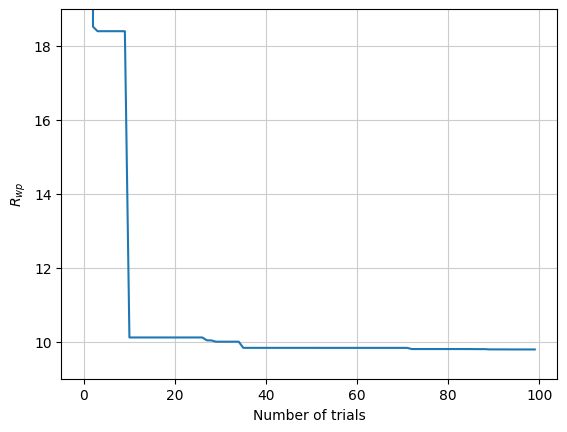

In [12]:
# Rwp plot
def rwp_plot():
    minvalues = [df.iloc[0]['Rwp']]
    for i in range(1, df.shape[0]):
        minvalues.append(min(minvalues[-1], df.iloc[i]['Rwp']))
    minvalues = pd.DataFrame(minvalues)
    
    minvalues.plot(legend=None)
    plt.ylim([9, 19])
    plt.grid(color='#cccccc')
    plt.ylabel('$R_{wp}$')
    plt.xlabel('Number of trials')
    plt.show()
    
rwp_plot()

Python gitpython module not installed
GSAS-II binary directory: /root/g2full/GSASII/bindist


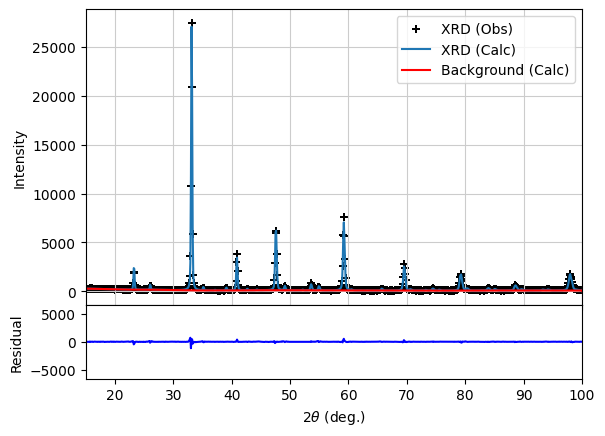

In [13]:
# Rietveld plot
def rietveld_plot():
    import GSASIIscriptable as G2sc

    gpx = G2sc.G2Project(
        f'{WORK_DIR}/project_seed{RANDOM_SEED}_trial_{study.best_trial.number}.gpx')

    hist1 = gpx.histograms()[0]
    phase0 = gpx.phases()[0]

    hist = hist1
    i = 5
    two_theta = hist.getdata("X")[::i]
    Yobs = hist.getdata("Yobs")[::i]
    Ycalc = hist.getdata("Ycalc")[::i]
    bg = hist.getdata("Background")[::i]
    residual = hist.getdata("Residual")[::i]

    fig = plt.figure()
    gs = GridSpec(5, 1, figure=fig)
    ax1 = fig.add_subplot(gs[:4, :])
    ax2 = fig.add_subplot(gs[4, :])
    fig.subplots_adjust(hspace=0)
    ax1.grid(color='#cccccc')

    ax1.scatter(two_theta, Yobs, marker='P', lw=0.0001, c='Black', label='XRD (Obs)')
    ax1.plot(two_theta, Ycalc, label='XRD (Calc)')
    ax1.plot(two_theta, bg, color='red', label='Background (Calc)')
    ax1.set_ylabel('Intensity')
    ax1.legend()
    ax2.plot(two_theta, residual, color='blue')
    plt.setp(ax1.get_xticklabels(), visible=False);
    ax2.set_ylim(-6600, 6600)
    plt.xlabel(r'$2\theta$ (deg.)')
    ax2.set_ylabel('Residual')
    ax1.set_xlim(config.two_t_min, config.two_t_max)
    ax2.set_xlim(config.two_t_min, config.two_t_max)
    plt.show()
    
rietveld_plot()